# EELS SrFeO Project 
## RNN Autoencoder

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*


#### Some resources to read on RNN Autoencoder

* <span style="color: red"> // put resources here // </span>

### Import Package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
hs.preferences.GUIs.warn_if_guis_are_missing = False

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  
 
# Do other imports now...
import keras

from keras.models import Model
from keras.layers import Input, LSTM, Dense, LeakyReLU
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

Using TensorFlow backend.


In [4]:
from keras import backend
backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
# checking device (GPU & CPU)
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8617345263532880114
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8221149251354060065
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10812804301
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9940597675494434381
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5599662366886948461
physical_device_desc: "device: XLA_GPU device"
]


## Load Data

In [6]:
#data = hs.load("processed_data/EELS_raw_*.hdf5")
import pickle
class Container(object): pass
temporal_data = list()
for k in range(19):
    f = pickle.load(open("processed_data/EELS_suprv_"+str(k)+".pkl", 'rb'))
    temporal_data.append(f)

In [7]:
temporal_data[0].O_range.shape

(30, 300, 81)

## Applying RNN Autoencoder to temporal data

### Downsampling

Done to reduce data size.

#### Resources
https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean

In [8]:
from scipy.signal import resample
import itertools

def downsample(stacked_data, N_resampled:int):
    """
    down sampling the data
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    N_resampled: int
        number of samples in the resampled set
    """
    dim = stacked_data[0].O_range.shape
    if N_resampled != dim[2]: 
        for k,sp in enumerate(stacked_data):
            stacked_data[k].resample = np.zeros((dim[0],dim[1], N_resampled))
        for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
            stacked_data[k].resample[i][j] = resample(stacked_data[k].data[i][j][:], N_resampled) 
    else:
        for k,sp in enumerate(stacked_data):
            stacked_data[k].resample = np.zeros((dim[0],dim[1], dim[2]))
        for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
            stacked_data[k].resample[i][j] = stacked_data[k].data[i][j][:]
    #for k in range(len(stacked_data)):
        #stacked_data[k].O_range = stacked_data[k].resample

In [9]:
np.array(temporal_data).shape

(19,)

In [10]:
N_resampled = 1000
#N_resampled = temporal_data[0].data.shape[2]
downsample(temporal_data, N_resampled)

### Section out region of interest (ROI)

In [11]:
def cut_ROI(data, N_resampled):
    '''
    Cutting region of interest to be analyzed
    
    Parameters
    -----------
    data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    
    N_resampled: int
        number of samples in the resampled set
    '''
    import math
    N_0 = data[0].data.shape[2]
    
    o_range = (750,900)
    fe_range = (2170,2350)
    anly_o_range = o_range[1] - o_range[0]
    anly_fe_range = fe_range[1] - fe_range[0]
    
    oc0 = math.ceil(o_range[0]/N_0*N_resampled)
    oc1 = math.ceil(o_range[1]/N_0*N_resampled)
    fc0 = math.ceil(fe_range[0]/N_0*N_resampled)
    fc1 = math.ceil(fe_range[1]/N_0*N_resampled)

    for k,spectra in enumerate(data):
        data[k].O_range = np.zeros((spectra.resample.shape[0], spectra.resample.shape[1], oc1-oc0))
        data[k].Fe_range = np.zeros((spectra.resample.shape[0], spectra.resample.shape[1], fc1-fc0))
        #print(math.ceil((o_range[1]+anly_o_range)/N_0*N_resampled))
        for i in range(spectra.resample.shape[0]):
            for j in range(spectra.resample.shape[1]):
                data[k].O_range[i][j] = spectra.resample[i][j][oc0:oc1]
                data[k].Fe_range[i][j] = spectra.resample[i][j][fc0:fc1]

In [12]:
#cut_ROI(temporal_data, N_resampled)

(30, 300, 81)


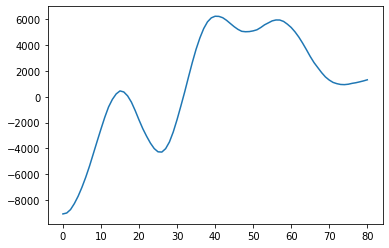

In [13]:
plt.plot(np.sum(temporal_data[2].O_range, axis=(0,1)))
print(temporal_data[0].O_range.shape)

### Visualize aggregated signals

Visualizing what we would expect from combined signals. This is just a quality assurance that we didn't do something real wrong. Signals should look smooth and pretty when SNR is high!

Text(0, 0.5, 'counts')

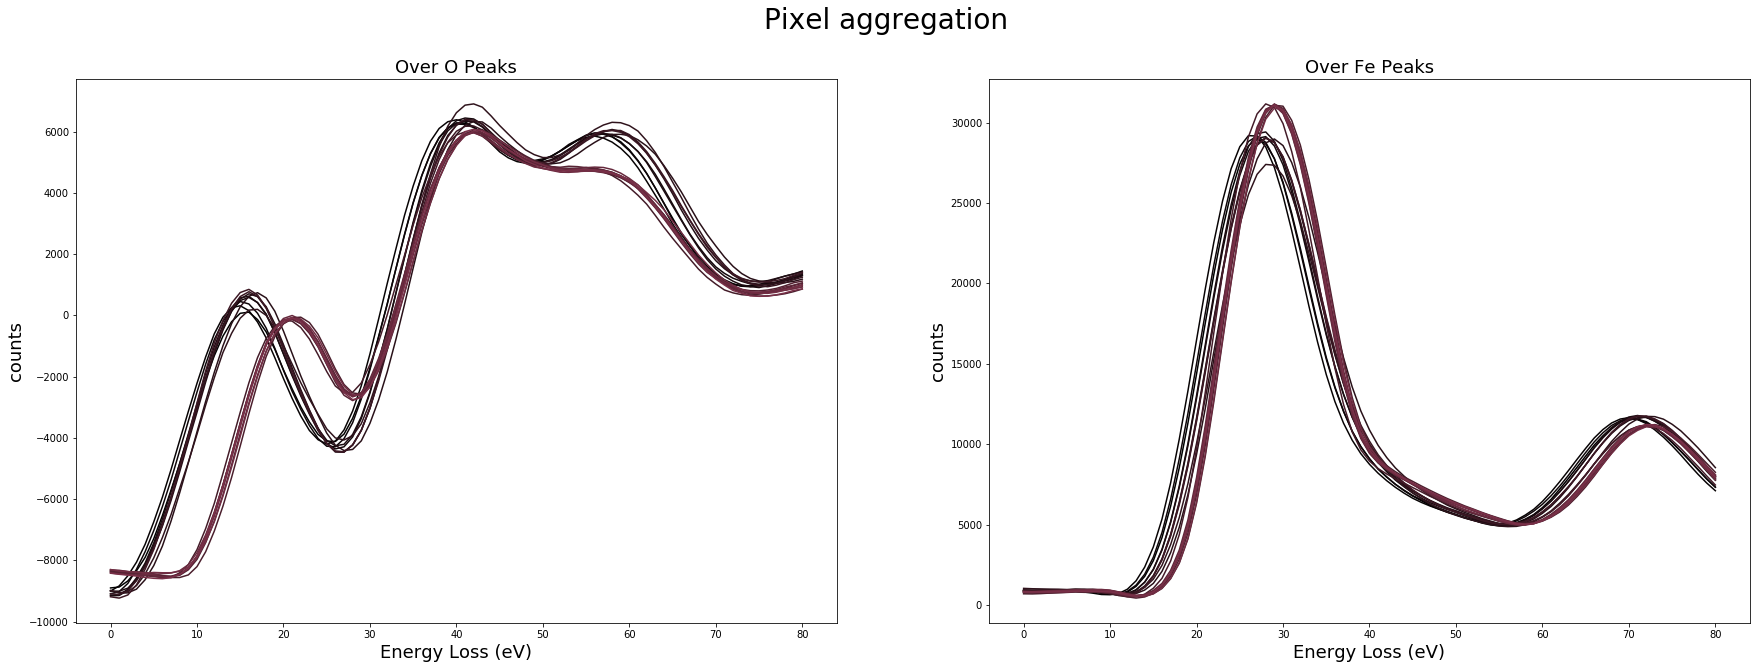

In [14]:
# visualizing raw data

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV

# Plotting aggregared spectra 
g,(ax3,ax4) = plt.subplots(1,2, figsize=(30,10))
for k in range(len(temporal_data)):
    # Plotting aggregation over oxygen range
    ax3.plot(np.sum(temporal_data[k].O_range, axis=(0,1)), color=(0.5*k/len(temporal_data), 0.2*k/len(temporal_data), 0.3*k/len(temporal_data)))
    # Plotting aggregation over Fe range
    ax4.plot(np.sum(temporal_data[k].Fe_range, axis=(0,1)), color=(0.5*k/len(temporal_data), 0.2*k/len(temporal_data), 0.3*k/len(temporal_data)))

# plot configurations
g.suptitle('Pixel aggregation', fontsize=28)

ax3.set_title('Over O Peaks', fontsize=18)
ax3.set_xlabel('Energy Loss (eV)', fontsize=18)
ax3.set_ylabel('counts', fontsize=18)   

ax4.set_title('Over Fe Peaks', fontsize=18)
ax4.set_xlabel('Energy Loss (eV)', fontsize=18)
ax4.set_ylabel('counts', fontsize=18)  

In [15]:
# rearrange dimension
arrayx = list()
array_target = list()
dim = temporal_data[0].O_range.shape
for i in range(len(temporal_data)):
    f = temporal_data[i].O_range.reshape((-1,dim[2]))
    g = temporal_data[i].target.reshape((-1,1))
    arrayx.append(f)
    array_target.append(g)
arrayx = np.array(arrayx).reshape((-1,dim[2]))
array_target = np.array(array_target).reshape((-1,1))

In [16]:
arrayx.shape

(171000, 81)

In [17]:
array_target.shape

(114000, 1)

### Setting up RNN autoencoder

In [18]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, LeakyReLU
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Conv2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [19]:
def rnn_autoencoder(layer, size, N_encode, 
                    N_decode, embed, 
                    N_steps, lr = 3e-6, drop_frac = 0.1,
                    bidir = False, l1_norm = 1e-4, **kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    N_encode  : numpy, int
        sets the number of encoding layers in the network
    N_decode : numpy, int
        sets the number of decoding layers in the network
    embed : numpy, int
        sets the size of the embedding layer
    N_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidir : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    model = Sequential()
    
    
    
    # wrapper for bidirectional LSTM
    if bidir: wrapper = Bidirectional
    else: wrapper = lambda x: x
        
        
    # builds the first layer
    model.add(wrapper(layer(size, return_sequences=(N_encode > 1),  dropout=drop_frac, input_shape=(N_steps, 1))))

    # builds the encoding layers
    for i in range(1, N_encode):
        model.add(wrapper(layer(size, return_sequences=(i < N_encode - 1), dropout=drop_frac)))

    # builds the embedding layer
    model.add(Dense(embed, activation='relu', name='encoding', activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(N_steps))

    # builds the decoding layer
    for i in range(N_decode):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

In [20]:
def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. 
        It is however limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.8f}.hdf5'
    
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                                 verbose=0, save_best_only=True,
                                                 save_weights_only=True, 
                                                 mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data_train), np.atleast_3d(data_train), 
              epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], 
              validation_data=(np.atleast_3d(data_test), np.atleast_3d(data_test)))

In [21]:
# construct a model
model3 = rnn_autoencoder(LSTM, 81, 3, 3, 9, 81)

In [22]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 81, 81)            26892     
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 81)            52812     
_________________________________________________________________
lstm_3 (LSTM)                (None, 81)                52812     
_________________________________________________________________
encoding (Dense)             (None, 9)                 738       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 81, 9)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 81, 81)            29484     
_________________________________________________________________
lstm_5 (LSTM)                (None, 81, 81)           

### Training RNN Autoencoder

In [23]:
# set learning rate and compile model
lr = 1e-5
model3.compile(Adam(lr), loss='mse')
folder_name = 'rnn_auto_deep2_checkpoints'

In [74]:
train_model(model3, arrayx, arrayx[:12000], folder_name, epochs=100, batch_size=200)

Train on 114000 samples, validate on 12000 samples
Epoch 1/100
114000/114000 [==============================] - 165s 1ms/step - loss: 0.1709 - val_loss: 0.1047
Epoch 2/100
114000/114000 [==============================] - 162s 1ms/step - loss: 0.1708 - val_loss: 0.1049
Epoch 3/100
114000/114000 [==============================] - 162s 1ms/step - loss: 0.1697 - val_loss: 0.1044
Epoch 4/100
114000/114000 [==============================] - 162s 1ms/step - loss: 0.1702 - val_loss: 0.1051
Epoch 5/100
114000/114000 [==============================] - 161s 1ms/step - loss: 0.1696 - val_loss: 0.1045
Epoch 6/100
114000/114000 [==============================] - 162s 1ms/step - loss: 0.1694 - val_loss: 0.1045
Epoch 7/100
114000/114000 [==============================] - 162s 1ms/step - loss: 0.1702 - val_loss: 0.1047
Epoch 8/100
114000/114000 [==============================] - 161s 1ms/step - loss: 0.1698 - val_loss: 0.1045
Epoch 9/100
 97000/114000 [========================>.....] - ETA: 23s - loss:

KeyboardInterrupt: 

### <span style="color:blue"> Training may take a few days depending on epochs. </span>
    At this point, just let the training run in the background. 
    Go to the next notebook to analyze the trained results.

## Load model

In [24]:
# load weights
model3.load_weights(folder_name+"/weights.99-0.10366738.hdf5")

# Compile model (required to make predictions)
lr = 5e-3
model3.compile(Adam(lr), loss='mse')

## Make Prediction

In [25]:
test = arrayx[:]
test.shape

(171000, 81)

In [26]:
predict = model3.predict(np.atleast_3d(test))

W1217 04:41:37.231109 140205942691648 deprecation_wrapper.py:119] From /home/pht219/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [27]:
predict.shape

(171000, 81, 1)

In [28]:
from sklearn import preprocessing
y1_norm = preprocessing.normalize(test)
y2_norm = preprocessing.normalize(predict.reshape(-1,81))
#y1_norm = test
#y2_norm = predict.reshape(-1,81)

Text(0.5, 0.98, 'Spectra Prediction - RNN Autoencoder (LSTM, 81, 3, 3, 9, 81)\n Labeled EELS data (anneal)')

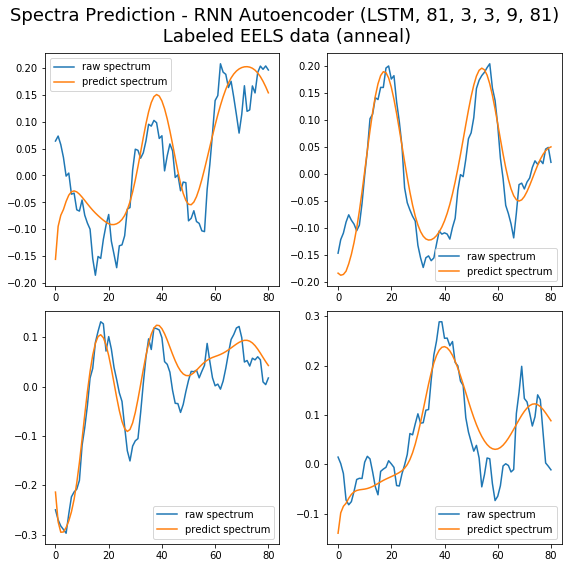

In [29]:
# Plotting Spectra Predictions (randomized for 36 spectra)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,2):
    for j in range(0,2):
        w = np.random.randint(0, y2_norm.shape[0])
        ax = axs[i,j]
        ax.plot(y1_norm[w], label="raw spectrum") 
        ax.plot(y2_norm[w], label="predict spectrum") 
        ax.legend(bbox_transform=ax.transAxes)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Spectra Prediction - RNN Autoencoder (LSTM, 81, 3, 3, 9, 81)"\
             "\n Labeled EELS data (anneal)", fontsize =18)

In [30]:
def get_ith_layer_output(model, X, i, mode='test'):
    """
    Computes the activations of a specific layer
    see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'
    
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
        
    Returns
    -------
    layer_output : float
        array containing the output from layer i of the network
    """
    # computes the output of the ith layer
    get_ith_layer = backend.function([model.layers[0].input, 
                                            backend.learning_phase()], 
                                           [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode == 'test' else 1])[0]

    return layer_output

In [31]:
activation = get_ith_layer_output(model3, np.atleast_3d(test), 3)

In [32]:
activation.shape

(171000, 9)

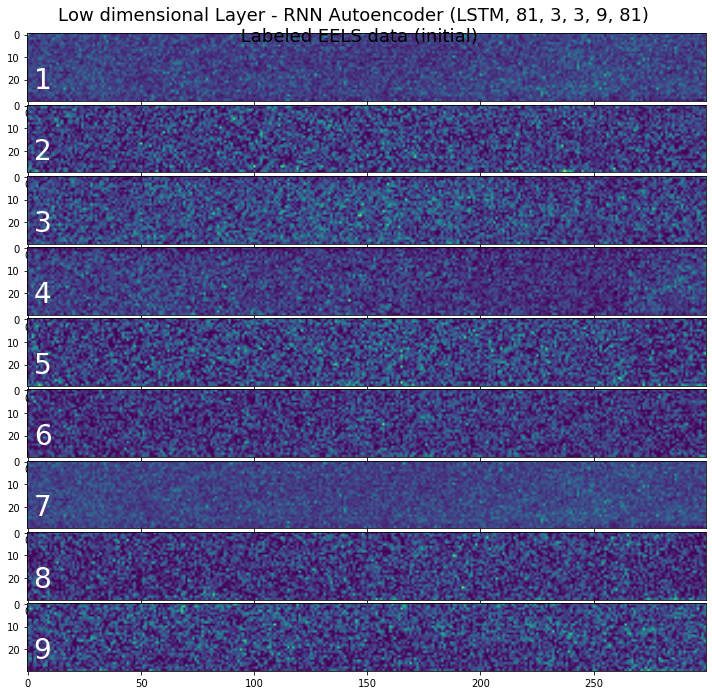

In [35]:
#actv = activation.reshape(int(test.shape[0]/(20*300)),30,300,9)
actv = activation.reshape(19,30,300,9)
fig, axs = plt.subplots(9, 1, figsize=(10, 10))
for k in range(9):
    ax = axs[k]
    ax.imshow(actv[0,:,:,k], cmap='viridis', interpolation='bilinear')
    #ax.pcolor(actv[0,:,:,k], cmap='viridis')
    ax.set_title(str(k+1), fontsize=28, color='white', loc='left', y=0.1, x=0.01)
fig.suptitle("Low dimensional Layer - RNN Autoencoder (LSTM, 81, 3, 3, 9, 81)"\
             " \n Labeled EELS data (initial)", fontsize=18)
plt.subplots_adjust(top=2.25)
plt.tight_layout()

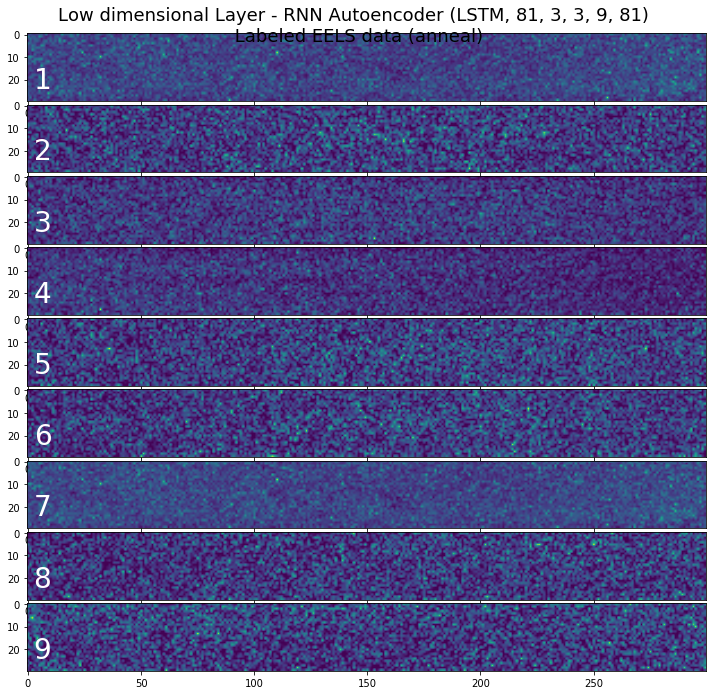

In [37]:
#actv = activation.reshape(int(test.shape[0]/(20*300)),30,300,9)
actv = activation.reshape(19,30,300,9)
fig, axs = plt.subplots(9, 1, figsize=(10, 10))
for k in range(9):
    ax = axs[k]
    ax.imshow(actv[3,:,:,k], cmap='viridis', interpolation='bilinear')
    #ax.pcolor(actv[3,:,:,k], cmap='viridis')
    ax.set_title(str(k+1), fontsize=28, color='white', loc='left', y=0.1, x=0.01)
fig.suptitle("Low dimensional Layer - RNN Autoencoder (LSTM, 81, 3, 3, 9, 81)"\
             " \n Labeled EELS data (anneal)", fontsize=18)
plt.subplots_adjust(top=2.25)
plt.tight_layout()

Text(946.5409090909088, 0.5, 'counts')

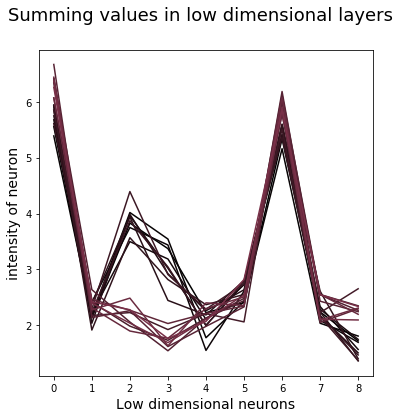

In [60]:
# visualizing activation layer

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV

# Plotting aggregared spectra 
g,(ax3) = plt.subplots(1,1, figsize=(6,6))
for k in range(len(actv)):
    # Plotting aggregation over oxygen range
    ax3.plot(np.sum(actv[k][5:15,150:170], axis=(0,1)), color=(0.5*k/len(actv), 0.2*k/len(actv), 0.3*k/len(actv)), label="les")
    #ax3.legend()
# plot configurations
g.suptitle('Summing values in low dimensional layers', fontsize=18)

#ax3.set_title('Over O Peaks', fontsize=18)
ax3.set_xlabel('Low dimensional neurons', fontsize=14)
ax3.set_ylabel('intensity of neuron', fontsize=14)   

ax4.set_title('Over Fe Peaks', fontsize=18)
ax4.set_xlabel('Energy Loss (eV)', fontsize=18)
ax4.set_ylabel('counts', fontsize=18)  

In [39]:
activation.shape

(171000, 9)

In [40]:
import sklearn 
pca = sklearn.decomposition.PCA(9)  # project from N_resampled to 2 dimensions
projected = pca.fit_transform(activation)

Text(0.5, 1.0, 'PCA explained variance of \nLow dimensional layer of RNN-Autoencoder')

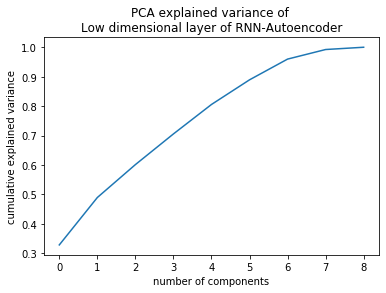

In [54]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("PCA explained variance of \nLow dimensional layer of RNN-Autoencoder")

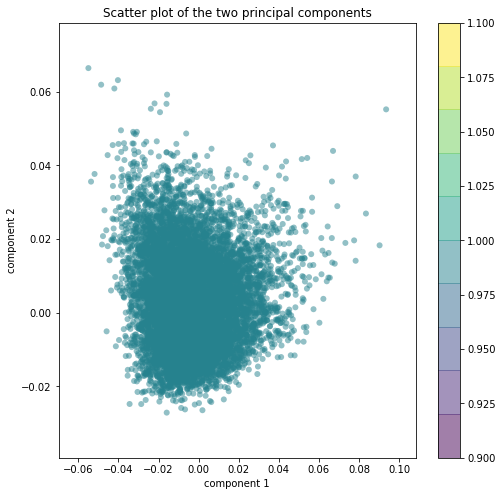

In [53]:
import matplotlib.cm as cm

plot_num = 5000
plot_range = (int(activation.shape[0]/2-plot_num),int(activation.shape[0]/2+plot_num))

plt.figure(figsize=(8,8))
plt.scatter(projected[plot_range[0]:plot_range[1], 0], projected[plot_range[0]:plot_range[1], 1],
            c=array_target.reshape((-1))[plot_range[0]:plot_range[1]], edgecolor='none', alpha=0.5,
            cmap=cm.get_cmap('viridis', 10))
plt.title("Scatter plot of the two principal components")
plt.xlabel('component 1')
plt.ylabel('component 2')
#plt.xlim(-60,150)
#plt.ylim(-60,60)
plt.colorbar();


## Setup and run PCA 

In [ ]:
data_target = list()
data_comb_o = list()
for i in range(len(temporal_data)):
    data_target.append(data_target)
    data_comb_o.append(data_comb_o)
data_target = np.array(data_target)
data_comb_o = np.array(data_comb_o)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
print(data_target.shape)
print(data_comb_o.shape)

In [ ]:
data_ana = data_comb_o.reshape((-1,data_comb_o.shape[3]))
data_tar = data_target.reshape((-1))
print(data_ana.shape)
print(data_tar.shape)

In [ ]:
pca = PCA(16)  # project from N_resampled to 2 dimensions
projected = pca.fit_transform(data_ana)
print(data_ana.shape)
print(projected.shape)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
X = projected
y = data_tar
y.shape

In [ ]:
testx = np.concatenate([X[:50000],X[130000:]])
testy = np.concatenate([y[:50000],y[130000:]])
trainx = X[50000:130000]
trainy = y[50000:130000]

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
model = SVC()
model.fit(trainx, trainy)

predictions = model.predict(testx)
cm4 = confusion_matrix(testy,predictions)

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(cm4)
plt.figure(figsize = (5,5))
ax = sn.heatmap(df_cm, annot=True, fmt='.1f')
for t in ax.texts: t.set_text(str(round(int(float(t.get_text()))/predictions.shape[0]*100, 2)) + " %")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title("ICA Confusion Matrix", fontsize=13)

## Trying with tSNE

In [99]:
import time
from sklearn.manifold import TSNE

In [100]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=True, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(activation[:])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 114000 samples in 0.074s...
[t-SNE] Computed neighbors for 114000 samples in 55.275s...
[t-SNE] Computed conditional probabilities for sample 1000 / 114000
[t-SNE] Computed conditional probabilities for sample 2000 / 114000
[t-SNE] Computed conditional probabilities for sample 3000 / 114000
[t-SNE] Computed conditional probabilities for sample 4000 / 114000
[t-SNE] Computed conditional probabilities for sample 5000 / 114000
[t-SNE] Computed conditional probabilities for sample 6000 / 114000
[t-SNE] Computed conditional probabilities for sample 7000 / 114000
[t-SNE] Computed conditional probabilities for sample 8000 / 114000
[t-SNE] Computed conditional probabilities for sample 9000 / 114000
[t-SNE] Computed conditional probabilities for sample 10000 / 114000
[t-SNE] Computed conditional probabilities for sample 11000 / 114000
[t-SNE] Computed conditional probabilities for sample 12000 / 114000
[t-SNE] Computed conditional proba

In [101]:
tsne_results.shape

(114000, 2)

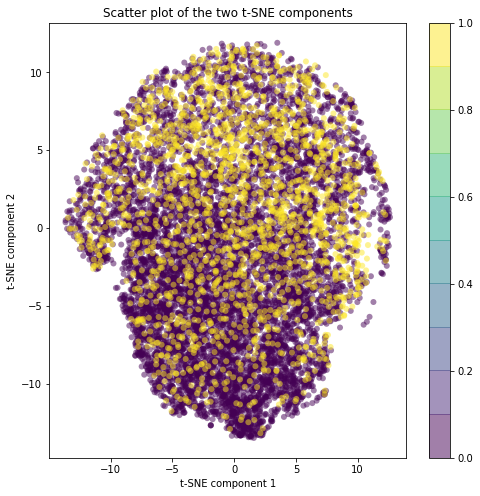

In [103]:
import matplotlib.cm as cm

plt.figure(figsize=(8,8))
plt.scatter(tsne_results[plot_range[0]:plot_range[1], 0], tsne_results[plot_range[0]:plot_range[1], 1],
            c=array_target.reshape((-1))[plot_range[0]:plot_range[1]], edgecolor='none', alpha=0.5,
            cmap=cm.get_cmap('viridis', 10))
plt.title("Scatter plot of the two t-SNE components")
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
#plt.xlim(-60,150)
#plt.ylim(-60,60)
plt.colorbar();
